# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

from smstools.models import utilFunctions as UF
from smstools.models import stft as STFT
from smstools.models import hpsModel as HPS
import IPython.display as ipd

Text(0.5, 1.0, 'magnitude spectrogram')

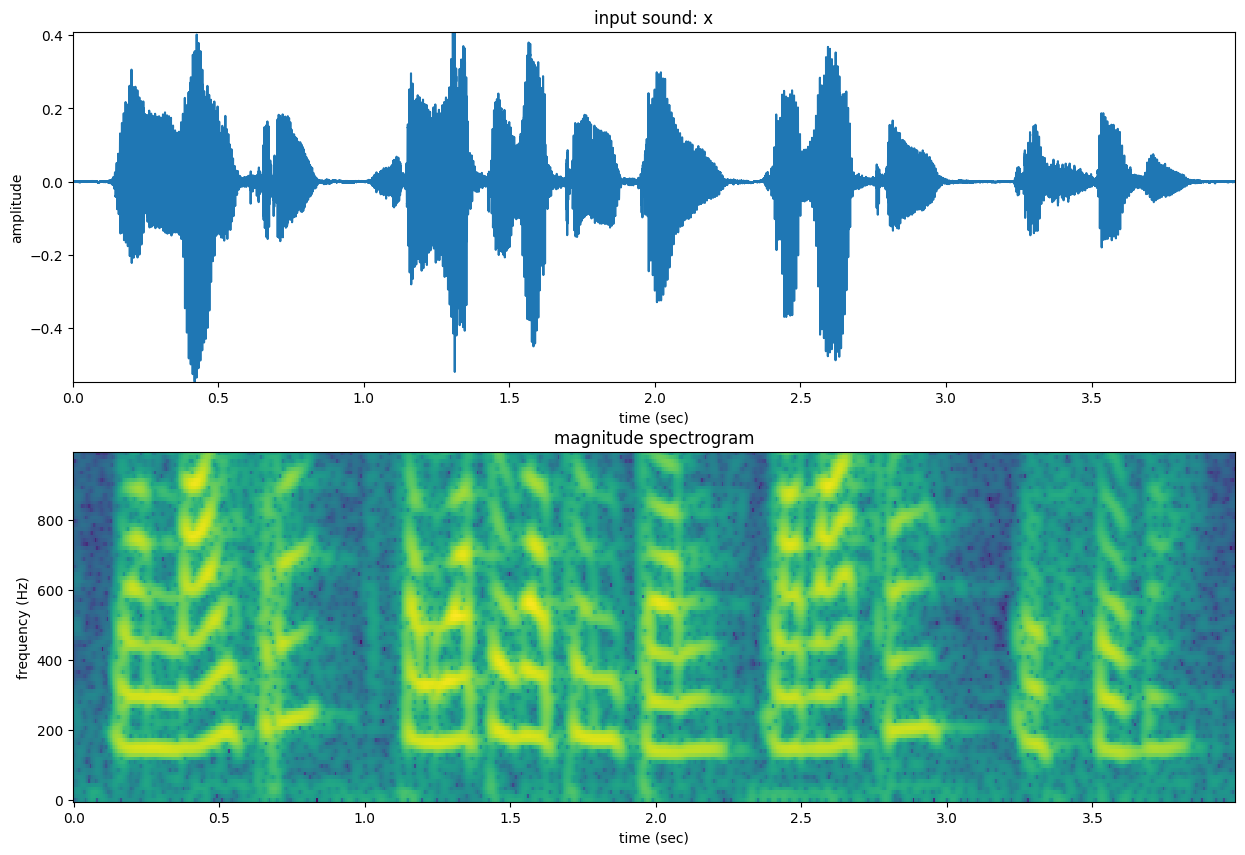

In [4]:
# E7 - 1.1: 
# Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters
window = 'blackmanharris'
M = 4095
N = 4096
H = 256

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [5]:
# E7 - 1.2: 
# Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='hamming'
M = 1023
N = 4096
t = -80
minSineDur = 0.1
nH = 17 
minf0 = 120
maxf0 = 280
f0et = 10
harmDevSlope = 0.01
stocf = 0.7

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question E7 - 1.3:**

### Explain the HPS analysis parameters used
____

### 1. Sound Description

The input file `speech-female.wav` contains a monophonic speech signal characterized by a clear separation between voiced (harmonic) and unvoiced (stochastic) sections. 
Through STFT analysis using a Blackman-Harris window, the spectrogram reveals a stable harmonic structure during vowels with a fundamental frequency ($f_0$) fluctuating approximately between 120Hz and 300Hz, typical of a female vocal range. While the spectral energy is rich in the lower frequencies, the harmonic definition degrades significantly above 3-4kHz, suggesting that a limited number of harmonics (around 15-20) is enough to capture the relevant tonal characteristics before the signal becomes predominantly stochastic.

### 2. Analysis Parameters

* **Window type (`hamming`):** I selected the Hamming window as it offers a good compromise between main-lobe width and side-lobe attenuation, suitable for separating the harmonics of speech.
* **Window size (`1023`):** A size of 1023 samples (approx. 23ms) provides sufficient time resolution to track rapid phoneme changes without sacrificing too much frequency resolution for the lower harmonics.
* **FFT size (`4096`):** I used a large FFT size to heavily interpolate the spectrum, ensuring accurate peak estimation for the fundamental frequency and harmonics.
* **Threshold (`-80`):** A threshold of -80dB was chosen to capture all significant spectral peaks while excluding the very low-level background noise.
* **Minimum f0 (`120`):** Visual inspection of the spectrogram showed the lowest pitch to be around 130Hz, so 120Hz was set as a safe lower bound to avoid false detections at lower frequencies.
* **Maximum f0 (`280`):** The highest pitch observed was slightly below 280Hz, so setting this tight upper bound prevents the algorithm from erroneously selecting higher harmonics as the fundamental.
* **Error threshold in f0 (`10`):** A relatively strict tolerance of 10 was selected to ensure that only clear, stable harmonic candidates are identified as pitch, reducing octave errors.
* **Number of harmonics (`17`):** Listening tests confirmed that 17 harmonics are sufficient to preserve the intelligibility and timbre of the voice, fulfilling the requirement for a compact representation.
* **Stochastic decimation factor (`0.7`):** While a lower factor provides more compression, I found that a value of 0.7 was necessary to maintain the natural texture of the stochastics.
* **Minimum sine duration (`0.1`):** I set this parameter to 0.1s to filter out short and unstable spurious tracks that do not contribute to the sustained vowels.

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

Processed audio saved to sad_violin_cut.wav
Playing Original Sound (Duration: 11.09s)


C:\Users\admin\AppData\Local\Temp\ipykernel_5140\1305805361.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(input_file)


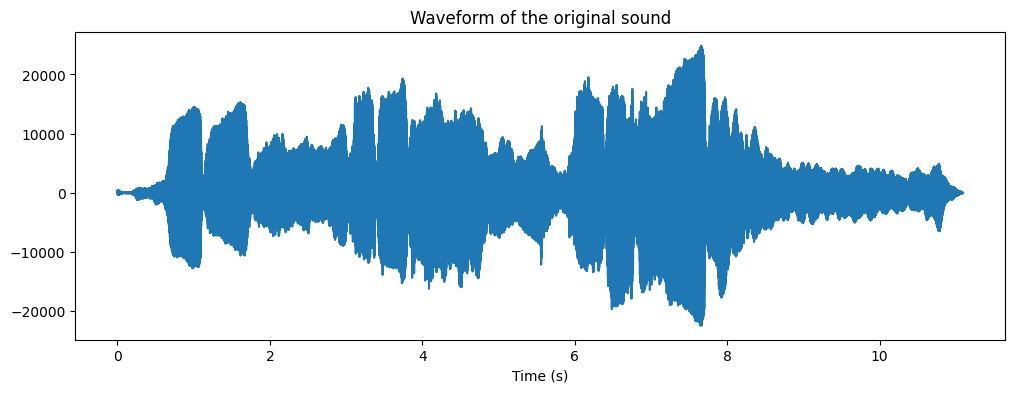

Playing Cut Sound (Duration: 5.00s)


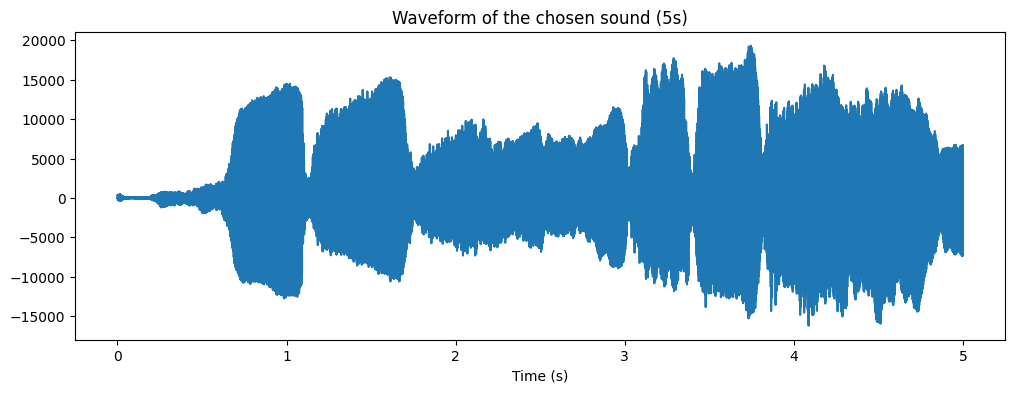

In [17]:
# E7 - 2.1: 
# Download a sound from freesound, read it with waveread, and describe it

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io import wavfile
from scipy.signal import resample
import os

# 1. Define file paths
# Ensure this matches the name of the WAV file you manually converted
input_file = "sad_violin_god_musing_800527__alixtwix6__11.wav"
output_path = "sad_violin_cut.wav"

if os.path.isfile(input_file):
    # 2. Load the audio file
    sr, audio = wavfile.read(input_file)

    # 3. Convert to mono if stereo
    if len(audio.shape) > 1:  # Check if the audio has more than one channel
        audio = np.mean(audio, axis=1)

    # 4. Resample to 44,100 Hz if necessary
    target_sr = 44100
    if sr != target_sr:
        num_samples = int(len(audio) * target_sr / sr)
        audio = resample(audio, num_samples)

    # 5. Cut to 5 seconds
    start_time = 0  # in seconds
    duration = 5    # in seconds (Assignment constraint)
    start_sample = int(start_time * target_sr)
    end_sample = start_sample + int(duration * target_sr)
    
    # Handle case where file is shorter than requested duration
    if end_sample > len(audio):
        end_sample = len(audio)

    audio_fragment = audio[start_sample:end_sample].astype(np.int16)

    # 6. Save the processed audio
    wavfile.write(output_path, target_sr, audio_fragment)
    print(f"Processed audio saved to {output_path}")

    # 7. Visualization and Playback
    print(f"Playing Original Sound (Duration: {len(audio)/sr:.2f}s)")
    ipd.display(ipd.Audio(data=audio, rate=sr))

    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(audio))/sr, audio)
    plt.title('Waveform of the original sound')
    plt.xlabel('Time (s)')
    plt.show()
    
    print(f"Playing Cut Sound (Duration: {len(audio_fragment)/target_sr:.2f}s)")
    ipd.display(ipd.Audio(data=audio_fragment, rate=target_sr))

    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(audio_fragment))/target_sr, audio_fragment)
    plt.title('Waveform of the chosen sound (5s)')
    plt.xlabel('Time (s)')
    plt.show()

else:
    print(f"Error: The file '{input_file}' was not found. Please check the filename.")

**Question E7 - 2.2:**

### write a brief description of the sound

I decided to analyze and synthesize the sound [Sad Violin God Musing](https://freesound.org/people/AlixTwix6/sounds/800527/) because:

- I absolutely love violin and string instruments.
- I love challenges, and violin is very difficult to analyse, especially for its **high number of harmonics** (still high energy in higher frequencies, the violin has very **high brightness**), and its **attacks** with the arch are **purely stochastic**, that's why they must be well-preserved to make the synthesised track sound realistic.

These are the characteristics of the sound I chose:

Tags: music, sad, violin

Type: Mp3 (.mp3)

Duration: 11.092 seconds

File size: 230.6 KB

Sample rate: 44100.0 Hz

Bitrate: 170 kbps

Channels: Stereo

I first converted it on **Audacity** into a monophonic sound in .wav format, with sample rate equal to 44100 Hz and samples in 16bit.

Then, I've extracted the first 5 seconds in order to start the STFT analysis.

Text(0.5, 1.0, 'magnitude spectrogram')

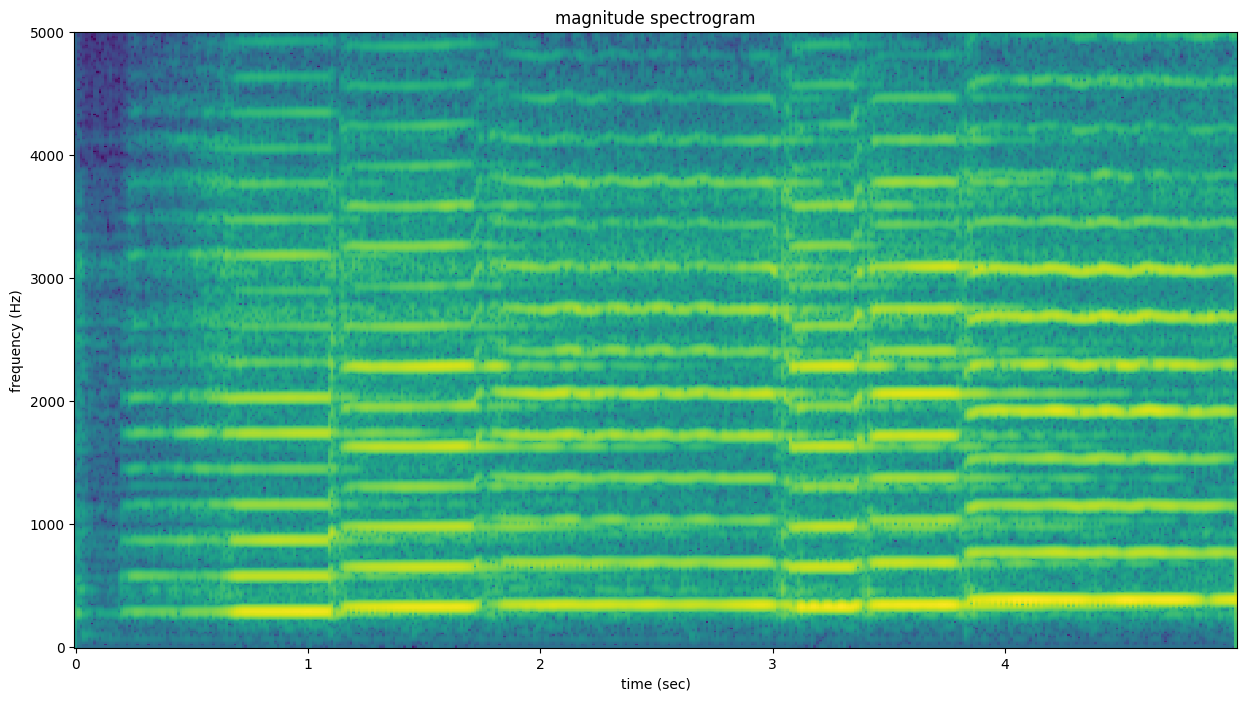

In [29]:
# E7 - 2.3: 
# Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model.

### basic visualization and listening of sound
input_file = 'sad_violin_cut.wav' # Use the mono, cut, and corrected WAV file
window = 'blackmanharris' 
M = 2047 # High window size (approx 46ms) for high frequency resolution, ideal for separating close harmonics
N = 4096 # FFT size for interpolation
H = 512  # Hop size

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

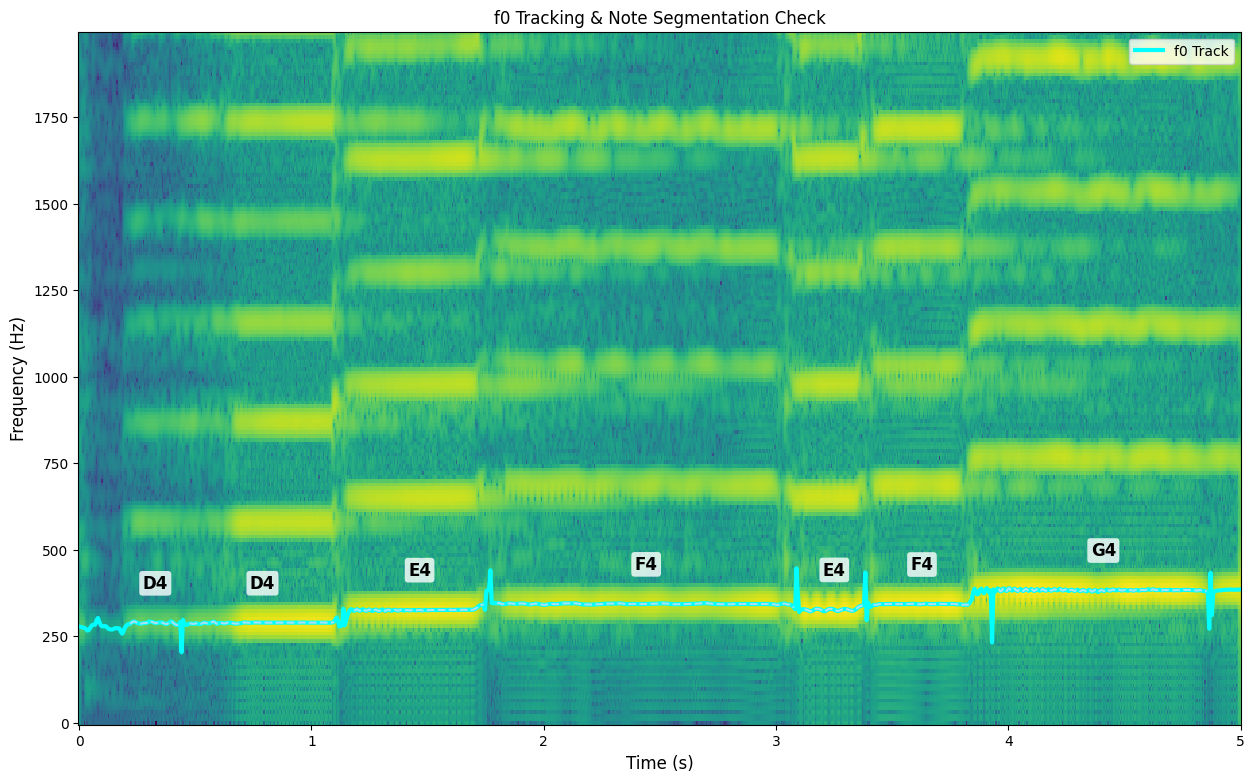

Original:


Detected Pitch Only (Synthetic):


In [ ]:
# Pitch stability analysis (f0) and note segmentation
# Useful to verify if the f0 tracking is correctly following the violin pitch

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import get_window
import sys, os
from smstools.models import harmonicModel as HM


eps = np.finfo(float).eps

def segment_stable_frequency_regions(f0, stdThsld, minNoteDur, winStable):
    """Segment the stable regions of a fundamental frequency track."""
    # convert f0 values from Hz to Cents
    f0Cents = 1200*np.log2((f0+eps)/55.0)

    # create an array containing standard deviation of last winStable samples
    stdArr = 10000000000*np.ones(f0.shape)
    for ii in range(winStable-1, len(f0)):
        stdArr[ii] = np.std(f0Cents[ii-winStable+1:ii+1])

    # apply threshold on standard deviation values to find stable points
    indFlat = np.where(stdArr<=stdThsld)[0]
    flatArr = np.zeros(f0.shape)
    flatArr[indFlat] = 1

    # create segments
    onset = np.where((flatArr[1:]-flatArr[:-1])==1)[0]+1
    offset = np.where((flatArr[1:]-flatArr[:-1])==-1)[0]

    # sync onset/offset
    indRem = np.where(offset<onset[0])[0]
    offset = np.delete(offset, indRem)
    minN = min(onset.size, offset.size)
    segments = np.transpose(np.vstack((onset[:minN], offset[:minN])))

    # apply segment filtering (minNoteDur)
    minNoteSamples = int(np.ceil(minNoteDur*fs/H))
    diff = segments[:,1] - segments[:,0]
    indDel = np.where(diff<minNoteSamples)
    segments = np.delete(segments,indDel, axis=0)

    return segments



input_file = 'sad_violin_cut.wav'

# f0 Parameters
minf0 = 190   # Approx G3
maxf0 = 450
f0et = 5      # Low error threshold for precision
window = 'hamming'
M = 1401      # Intermediate window size
N = 4096
H = 256       # Denser hop size for better visualization
t = -90

# Segmentation Parameters
stdThsld = 30    # Increased to 30 cents to tolerate violin VIBRATO
minNoteDur = 0.1 # Minimum note duration
winStable = 5    # Window for stability calculation


if os.path.isfile(input_file):
    # compute f0 and segments
    fs, x = UF.wavread(input_file)
    w  = get_window(window, M)
    
    # 1. f0 Detection
    f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
    
    # 2. Segmentation
    segments = segment_stable_frequency_regions(f0, stdThsld, minNoteDur, winStable)

    # Helper functions for labels
    def freq_to_midi(frequency):
        return 69 + 12 * np.log2(frequency / 440.0)

    def midi_to_note_name(midi_number):
        note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        octave = (midi_number // 12) - 1
        note = note_names[midi_number % 12]
        return f"{note}{octave}"

    # 3. Plotting
    maxplotfreq = 2000.0 # Zoom on low frequencies to see f0 clearly

    plt.figure(figsize=(15, 9))

    mX, pX = STFT.stftAnal(x, w, N, H)
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

    timeStamps = np.arange(mX.shape[1])*H/float(fs)
    binFreqs = np.arange(mX.shape[0])*fs/float(N)

    # Synthesis of f0 only (to hear what the computer detected)
    note_idx = np.concatenate([np.arange(*segment) for segment in segments]) if len(segments) > 0 else []
    note_f0 = np.zeros_like(f0)
    if len(note_idx) > 0:
        note_f0[note_idx] = f0[note_idx]
    y = UF.sinewaveSynth(note_f0, 0.5, H, fs)

    plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
    
    # Plot f0 track in cyan
    plt.plot(timeStamps, f0, color = 'cyan', linewidth=3, label='f0 Track')

    # Highlight stable segments
    for i in range(segments.shape[0]):
        plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5, linestyle='--')
        
        # Note labels
        segment_center = (timeStamps[segments[i,0]] + timeStamps[segments[i,1]]) / 2
        segment_f0 = np.mean(f0[segments[i,0]:segments[i,1]])
        if segment_f0 > 0:
            midi_number = int(np.round(freq_to_midi(segment_f0)))
            note_name = midi_to_note_name(midi_number)
            plt.text(segment_center, segment_f0 + 100, f'{note_name}', color='black', fontsize=12, ha='center', fontweight='bold',
                     bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8))

    plt.ylabel('Frequency (Hz)', fontsize = 12)
    plt.xlabel('Time (s)', fontsize = 12)
    plt.title('f0 Tracking & Note Segmentation Check')
    plt.legend()
    plt.show()

    print("Original:")
    ipd.display(ipd.Audio(data=x, rate=fs))
    print("Detected Pitch Only (Synthetic):")
    ipd.display(ipd.Audio(data=y, rate=fs))
else:
    print("File not found.")

**Question E7 - 2.4:**

### Describe the characteristics relevant to perform the harmonic plus stochastic analysis
____

The spectrogram reveals a highly harmonic sound typical of a bowed string instrument, with a **fundamental frequency** $f_0$ ranging approximately between **200 Hz and 450 Hz**. The harmonic series is very dense and maintains high energy up to the 5000 Hz limit shown in the plot, indicating a very bright timbre that will require a high number of harmonics (e.g., **nH > 40**) for accurate reconstruction. The harmonic tracks show visible frequency modulation (**vibrato**), and there are stochastic components at the note transitions (visible as vertical blurs around 1s, 1.8s, 3s, 3.4s and 3.8s) corresponding to the bow noise, which justifies the use of the stochastic residual model.



In [56]:
# E7 - 2.5: 
# Perform Harmonic plus Stochastic analysis and synthesis of chosen sound.


### fill the parameters
input_file = 'sad_violin_cut.wav' # Use the mono, cut, and corrected WAV file
window ='blackmanharris'
M = 1401
N = 4096
t = -90
minSineDur = 0.02
nH = 50 # high number of harmonics to track due to the brightness of the violin sound 
minf0 = 190
maxf0 = 450
f0et = 10
harmDevSlope = 0.02
stocf = 0.1

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question E7 - 2.5**

### Explain the choices of HPS analysis parameters
___

**Question E7 - 2.5 Explain the choices of HPS analysis parameters**

To achieve the best reconstruction, I performed an iterative process testing multiple configurations. Initially, I tried a large window (`M=2047`) to capture the low frequency of the string, but this resulted in smeared attacks. Instead, a shorter window (`M=1023`) improved the transient response but caused instability in the pitch tracking of the vibrato. I also experimented with `minSineDur=0.1`, but this caused the model to lose harmonic tracking during the legato transitions, creating heavy noise artifacts. The final configuration below represents the best trade-off found:

* **Window type (`blackmanharris`):** I chose the Blackman-Harris window for its excellent side-lobe rejection, which is crucial to minimize spectral leakage given the dense harmonic structure of the violin.
* **Window size (`1401`):** A window size of 1401 samples (approx. 31ms) provided sufficient frequency resolution to resolve the 190Hz fundamental while maintaining sharp temporal resolution for the bow attacks.
* **FFT size (`4096`):** I used an FFT size of 4096 to ensure high spectral interpolation for accurate peak detection.
* **Threshold (`-90`):** I set a low threshold of -90dB to capture the full dynamic range of the violin, including the decaying harmonics.
* **Minimum f0 (`190`):** Set to 190Hz to safely cover the violin's lowest open string (G3 ~196Hz).
* **Maximum f0 (`450`):** Capped at 450Hz based on the visual inspection of the STFT spectrogram.
* **Error threshold in f0 (`10`):** I selected an error threshold of 10, which is strict enough to ensure stable tracking but allows enough tolerance for the natural vibrato of the performance.
* **Number of harmonics (`50`):** Because the violin has a very high brightness, I used 50 harmonics to capture the spectral energy up to high frequencies.
* **Slope of harmonic deviation (`0.02`):** I allowed a slope of 0.02 to account for the slight natural inharmonicity of the strings (stiffness) and the vibrato, preventing valid harmonics from being discarded into the residual.
* **Minimum sine duration (`0.02`):** I drastically reduced this to 0.02s to ensure that short and transient harmonic segments during the fast note attacks were preserved and not interpreted as noise.
* **Stochastic decimation factor (`0.1`):** A factor of 0.1 provided the most compact representation that sufficiently smoothed the residual envelope to model the "breath" of the bow without granular artifacts.

Overall, this configuration leads to a very faithful reconstruction of the original timbre. However, a slight stochastic noise effect remains audible specifically during the final bow attack. This artifact was difficult to remove completely, likely due to the high inharmonicity of the transient phase where the distinction between the harmonic and stochastic components becomes ambiguous for the model.